In [2]:

import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.animation as animation              
import matplotlib.patches as patches

N = 100  # number of atoms
duration = 20
nsteps = 1000
dt = duration/nsteps
L = int(N**0.5)
E_0 = 1
positions = np.zeros((N,2))
velocities = np.zeros_like(positions)
forces = np.zeros_like(positions)
atoms = []
rc = 2.5 #cutoff distance

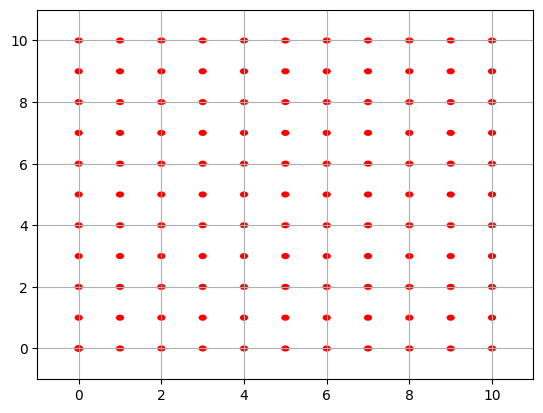

In [3]:
#initialisation

fig, ax = plt.subplots()

def init(positions,velocities):
    i = -1
    for j in range (L):
        for k in range (L):
            i += 1
            positions[i][0] = j 
            positions[i][1] = k 


    for i in range(0,N):
        theta = random.uniform(0.0,2*np.pi)
        velocities[i][:] = [np.cos(theta),np.sin(theta)]

    

    for i in range (N):
        atom = patches.Circle((positions[i,0],positions[i,1]),0.1,facecolor='red')
        ax.add_patch(atom)
        atoms.append(atom)

init(positions,velocities)
ax.set_xlim(-1,L )
ax.set_ylim(-1 ,L )
ax.grid()


In [4]:
# forces 

def interact_closer_pict(x):
    if x > L:
        return x - L
    if x < 0:
        return x + L
    else:
        return x

def forces_computation(positions,forces):
    for i in range (0,N-1):
        for j in range(i+1,N):
            dx = positions[i][0] - positions[j][0]
            dy = positions[i][1] - positions[j][1]
            dx = interact_closer_pict(dx)
            dy = interact_closer_pict(dy)

            if dx*dx + dy*dy < rc**2:
                force = 0
            else:
                r2_inv = 1/(dx*dx + dy*dy)
                force = 24*E_0* r2_inv**7 * (2*r2_inv**6 +1)
            
            forces[i,0] += force*dx
            forces[i,1] += force*dy

            forces[j,0] += -force*dx
            forces[j,1] += -force*dy
    return forces

        

In [5]:
# evolution of particules at each time step (using verlet algorithm)
 
def step_evolution(positions,velocities,forces):
    dt2 = dt*dt
    
    positions = positions + dt*velocities + 0.5*dt2*forces
    
    next_forces = forces_computation(positions,forces) 
    velocities = velocities + 0.5*dt2*(forces+next_forces)
    
    forces = next_forces
    return positions,velocities

In [6]:
# collecting all the data through the duration of the animation

all_positions = np.zeros((nsteps,N,2))
all_velocities = np.zeros_like((all_positions))

for t in range (0,nsteps):
    all_positions[t,:,:],all_velocities[t,:,:] = step_evolution(positions,velocities,forces)





In [7]:
print(all_positions[500,:,0]%L)

[1.98637129e-02 1.09800072e+01 2.00024974e-02 1.97172263e-02
 1.29369351e-02 1.09834112e+01 1.09979640e+01 8.74090567e-03
 1.09811541e+01 1.14846972e-02 1.09824991e+01 1.01586731e+00
 1.01751749e+00 1.01605715e+00 1.00270542e+00 1.01708293e+00
 9.80030321e-01 1.01843993e+00 9.87028879e-01 1.01915064e+00
 1.00251272e+00 1.01256616e+00 1.98054973e+00 2.00915367e+00
 1.99352729e+00 1.98087201e+00 2.01913645e+00 1.98241643e+00
 2.01314696e+00 2.01000393e+00 2.00099821e+00 2.01807110e+00
 2.00432341e+00 3.00961004e+00 3.01277658e+00 2.98014021e+00
 3.01513737e+00 2.98382286e+00 2.98202331e+00 3.01794264e+00
 2.98192624e+00 2.98732674e+00 3.01186834e+00 2.99016644e+00
 4.01996420e+00 3.99077103e+00 4.01397732e+00 3.98124766e+00
 4.01799228e+00 4.01045347e+00 4.01482107e+00 4.00820967e+00
 3.98379948e+00 3.98071036e+00 4.01825771e+00 5.01698352e+00
 4.98672495e+00 4.98007603e+00 5.01501429e+00 4.98487482e+00
 4.98525984e+00 5.01147205e+00 5.01921877e+00 5.00518588e+00
 4.99945654e+00 5.019622

In [11]:
#speeds = np.linalg.norm(all_velocities, axis=2)




def anim(t):
    for i in range(N):
        x,y = all_positions[t,i,0]%(L) , all_positions[t,i,1]%(L)
        atoms[i].center = x,y
        ax.set_xlim(-1,L+1)
        ax.set_ylim(-1,L+1)
        
    
interval = duration*1e3/nsteps
ani = animation.FuncAnimation(fig, anim, frames = nsteps, interval=interval, repeat=False)
ani.save('lennard_jones_simulation.gif', writer='pillow')


